In [ ]:
!pip install fortitudo.tech

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [ ]:
R_df = ft.load_pnl()
instrument_names = R_df.columns

stats_prior = ft.simulation_moments(R_df)
stats_prior.iloc[:, 0:2] = stats_prior.iloc[:, 0:2].mul(100)
display(np.round(stats_prior, 2))

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.70,3.18,0.10,3.02
Corp IG,-0.40,3.39,0.11,3.11
Corp HY,1.92,6.12,0.17,2.97
EM Debt,2.74,7.51,0.22,3.06
DM Equity,6.40,14.85,0.40,3.15
EM Equity,8.00,26.87,0.77,4.10
Private Equity,13.70,27.77,0.72,3.76
Infrastructure,5.87,10.83,0.31,3.19
Real Estate,4.32,8.15,0.23,3.09
Hedge Funds,4.80,7.24,0.20,3.05


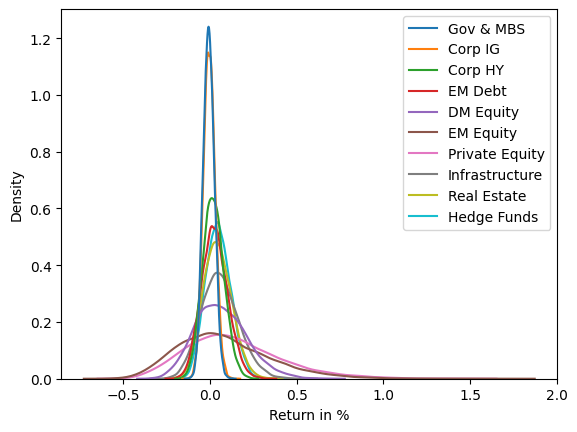

In [ ]:
sns.kdeplot(R_df)
plt.xlabel('Return in %')
plt.show()

# Entropy Pooling views
mean of Private Equity is 10%, volatility of EM
Equity is less than or equal to 20%, skewness of DM Equity is less than or equal to −0.75, kurtosis of
DM Equity is greater than or equal to 3.5, and correlation between Corp HY and EM Debt is 50%.

# Original heuristic

In [ ]:
R = R_df.values
S = R.shape[0]
p = np.ones((S, 1)) / S
means_prior = p.T @ R
vols_prior = np.sqrt(p.T @ (R - means_prior)**2)

mean_rows = R[:, 2:7].T
vol_rows = (R[:, 2:6] - means_prior[:, 2:6]).T**2
skew_row = ((R[:, 4] - means_prior[:, 4]) / vols_prior[:, 4])**3
kurt_row = ((R[:, 4] - means_prior[:, 4]) / vols_prior[:, 4])**4
corr_row = (R[:, 2] - means_prior[:, 2]) * (R[:, 3] - means_prior[:, 3])

A = np.vstack((np.ones((1, S)), mean_rows, vol_rows[0:-1, :], corr_row[np.newaxis, :]))
b = np.vstack(([1], means_prior[:, 2:6].T, [0.1], vols_prior[:, 2:5].T**2,
               [0.5 * vols_prior[0, 2] * vols_prior[0, 3]]))
G = np.vstack((vol_rows[-1, :], skew_row, -kurt_row))
h = np.array([[0.2**2], [-0.75], [-3.5]])

In [ ]:
q = ft.entropy_pooling(p, A, b)
relative_entropy = q.T @ (np.log(q) - np.log(p))
effective_number_scenarios = np.exp(-relative_entropy)
print(f'RE = {np.round(relative_entropy[0, 0], 3)}.')
print(f'Relative ENS = {np.round(effective_number_scenarios[0, 0], 3)}.')

RE = 0.047.
Relative ENS = 0.954.


In [ ]:
stats_prior = ft.simulation_moments(R_df)
display(stats_prior)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.006976,0.031783,0.096295,3.022619
Corp IG,-0.003992,0.033873,0.106534,3.108871
Corp HY,0.019181,0.061198,0.173196,2.970604
EM Debt,0.027368,0.075091,0.217050,3.056793
DM Equity,0.063959,0.148501,0.396034,3.148418
EM Equity,0.080040,0.268654,0.766393,4.098948
Private Equity,0.136994,0.277711,0.716215,3.758005
Infrastructure,0.058655,0.108266,0.311013,3.192734
Real Estate,0.043207,0.081489,0.234063,3.092417
Hedge Funds,0.048017,0.072393,0.204416,3.050429


In [ ]:
ft.simulation_moments(R_df, q)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.005646,0.032035,0.102251,3.014942
Corp IG,-0.004415,0.033470,0.091498,3.083219
Corp HY,0.019181,0.061198,0.190830,3.005364
EM Debt,0.027367,0.075091,0.221591,3.022426
DM Equity,0.063959,0.148501,0.418186,3.223520
EM Equity,0.080040,0.265495,0.780099,4.214239
Private Equity,0.100000,0.262701,0.696970,3.771963
Infrastructure,0.054989,0.107691,0.313852,3.224878
Real Estate,0.037952,0.080729,0.242094,3.091068
Hedge Funds,0.046029,0.072272,0.237405,3.147902


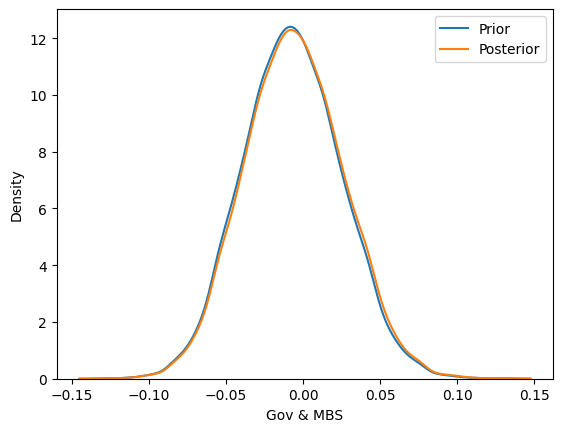

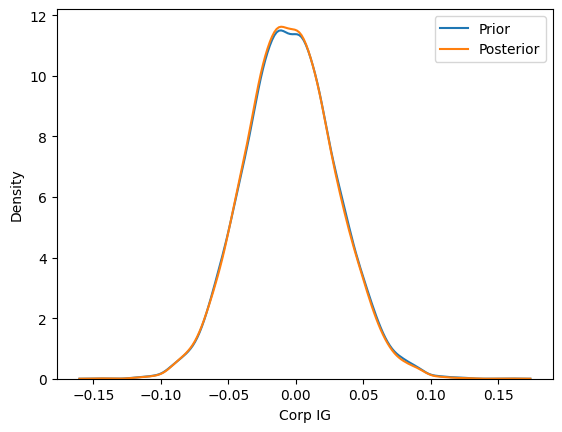

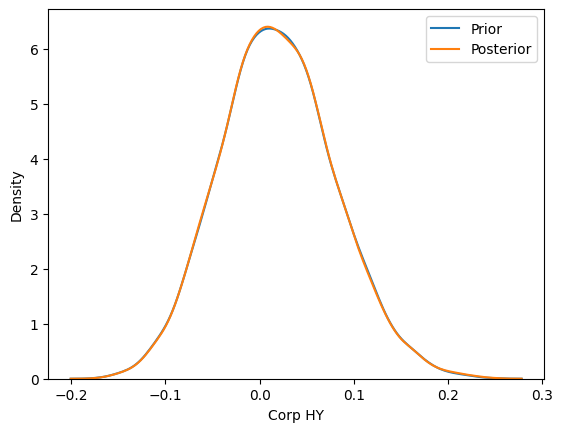

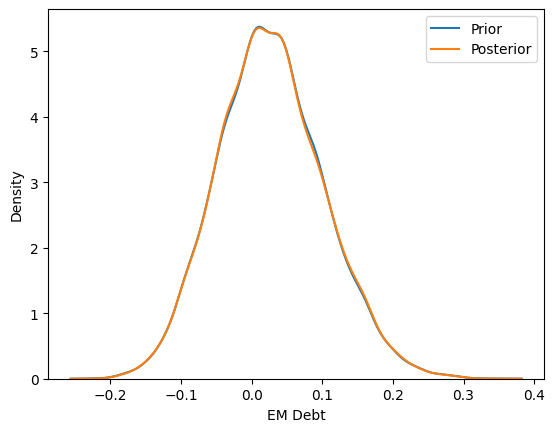

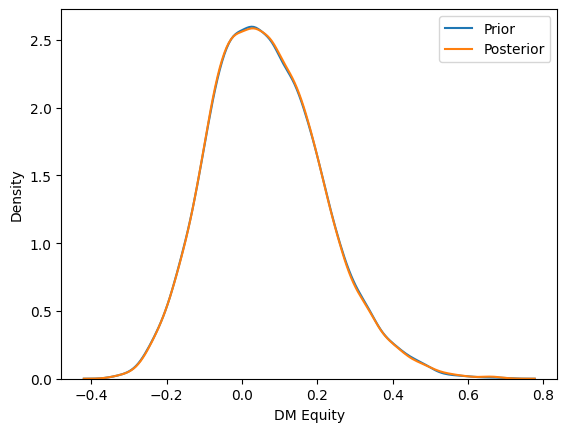

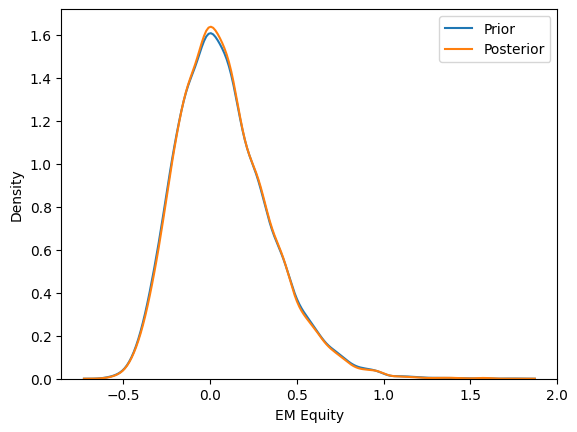

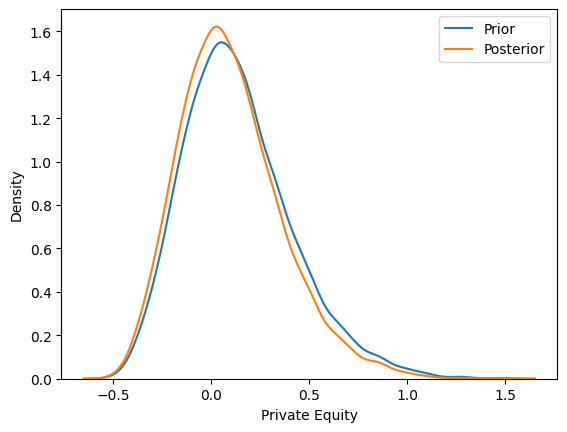

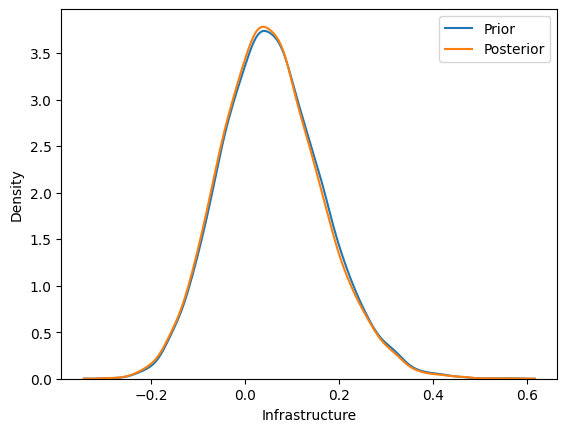

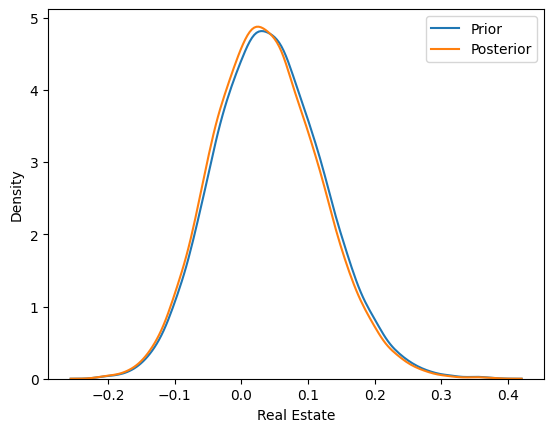

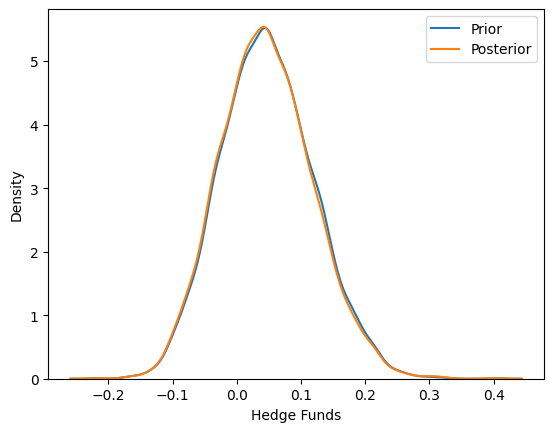

In [ ]:
for i in range(10):
  sns.kdeplot(x=R_df.iloc[:, i])
  sns.kdeplot(x=R_df.iloc[:, i], weights=q[:, 0])
  plt.legend(['Prior', 'Posterior'])
  plt.show()

# Sequential heuristic (H1)
See https://ssrn.com/abstract=3936392 for more information.

In [ ]:
# C0 views
mean_row = R[:, 1][np.newaxis]
A0 = np.vstack((np.ones((1, S)), mean_row))
b0 = np.array([[1.], [0.1]])
q0 = ft.entropy_pooling(p, A0, b0)

In [ ]:
ft.simulation_moments(R_df, q0)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,0.052059,0.035737,-0.266208,2.265610
Corp IG,0.100000,0.044309,-0.181936,2.128673
Corp HY,0.096963,0.054581,-0.187032,3.268894
EM Debt,0.163537,0.080470,-0.513780,2.418053
DM Equity,0.138907,0.143354,-0.298493,2.541248
EM Equity,0.236400,0.252120,0.413821,4.009514
Private Equity,0.309116,0.298377,-0.188268,2.031546
Infrastructure,0.173938,0.155932,-0.087321,1.786859
Real Estate,0.096609,0.083638,-0.573675,2.526741
Hedge Funds,0.126293,0.074791,-0.099078,4.009661


In [ ]:
# C1 views
G = np.vstack((vol_rows[-1, :], skew_row, -kurt_row))
h = np.array([[0.2**2], [-0.75], [-3.5]])
means0 = q0.T @ R
G1 = np.vstack((np.ones((1, S)),vol_rows[-1, :]))
h1 = np.array([[1.],[0.2**2]])
q1 = ft.entropy_pooling(p, A0, b0,G1,h1)

In [ ]:
ft.simulation_moments(R_df, q1)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,0.054774,0.035654,-0.371903,2.323417
Corp IG,0.100000,0.044837,-0.170081,2.082054
Corp HY,0.088799,0.049755,-0.112197,3.493298
EM Debt,0.155484,0.078428,-0.382654,2.199343
DM Equity,0.125618,0.136872,-0.336705,2.008845
EM Equity,0.168497,0.179375,-0.297939,2.611375
Private Equity,0.285589,0.293248,-0.161561,1.781404
Infrastructure,0.173096,0.157480,-0.074595,1.765372
Real Estate,0.089374,0.084538,-0.400003,2.281638
Hedge Funds,0.115472,0.066862,-0.501841,2.197843


In [ ]:
# C2 views
G = np.vstack((vol_rows[-1, :], skew_row, -kurt_row))
h = np.array([[0.2**2], [-0.75], [-3.5]])
means0 = q0.T @ R
G2 = np.vstack((np.ones((1, S)),vol_rows[-1, :],skew_row))
h2 = np.array([[1.],[0.2**2],[-0.75]])
q2 = ft.entropy_pooling(p, A0, b0,G2,h2)
ft.simulation_moments(R_df, q2)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,0.057860,0.032510,-0.302007,2.512401
Corp IG,0.100000,0.038539,-0.048587,2.475279
Corp HY,0.078716,0.048820,-0.088497,3.314309
EM Debt,0.142631,0.074625,-0.154722,2.378086
DM Equity,0.054061,0.170007,-0.324997,2.192504
EM Equity,0.090297,0.199737,-0.377252,2.435285
Private Equity,0.170861,0.327145,0.098555,1.791087
Infrastructure,0.148807,0.150632,0.132247,1.943273
Real Estate,0.070727,0.084268,-0.213487,2.490614
Hedge Funds,0.090356,0.077991,-0.329623,2.020384


In [ ]:
# C3 views
G = np.vstack((vol_rows[-1, :], skew_row, -kurt_row))
h = np.array([[0.2**2], [-0.75], [-3.5]])
means0 = q0.T @ R
G3 = np.vstack((np.ones((1, S)),vol_rows[-1, :],skew_row,-kurt_row))
h3 = np.array([[1.],[0.2**2],[-0.75],[-3.5]])
q3 = ft.entropy_pooling(p, A0, b0,G3,h3)
ft.simulation_moments(R_df, q3)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,0.057860,0.032510,-0.302007,2.512401
Corp IG,0.100000,0.038539,-0.048587,2.475279
Corp HY,0.078716,0.048820,-0.088497,3.314309
EM Debt,0.142631,0.074625,-0.154722,2.378086
DM Equity,0.054061,0.170007,-0.324997,2.192504
EM Equity,0.090298,0.199737,-0.377252,2.435285
Private Equity,0.170861,0.327145,0.098555,1.791087
Infrastructure,0.148807,0.150632,0.132247,1.943273
Real Estate,0.070727,0.084268,-0.213488,2.490614
Hedge Funds,0.090356,0.077991,-0.329623,2.020384


In [ ]:
relative_entropy1 = q3.T @ (np.log(q3) - np.log(p))
effective_number_scenarios1 = np.exp(-relative_entropy1)
print(f'RE = {np.round(relative_entropy1[0, 0], 3)}.')
print(f'Relative ENS = {np.round(effective_number_scenarios1[0, 0], 3)}.')

RE = 4.391.
Relative ENS = 0.012.


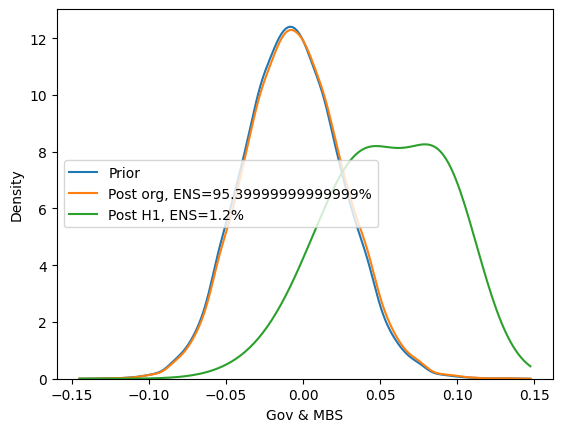

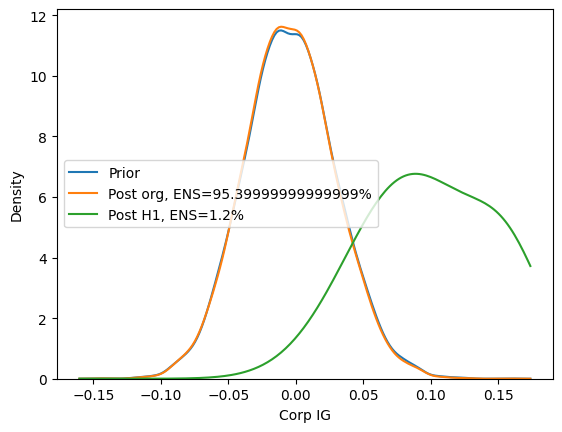

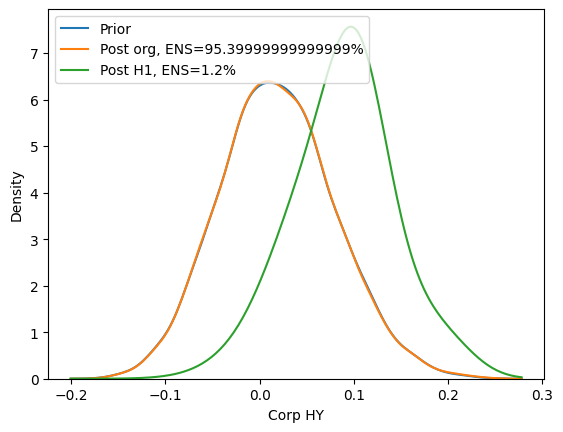

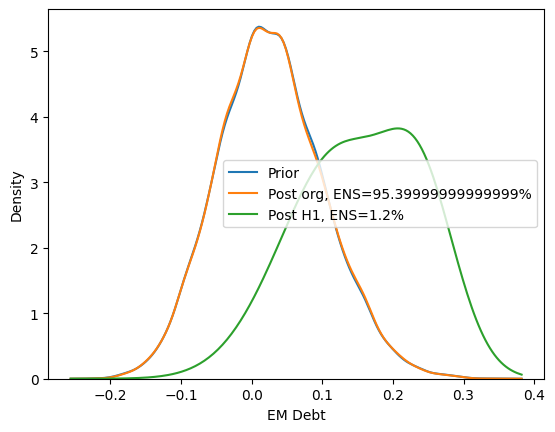

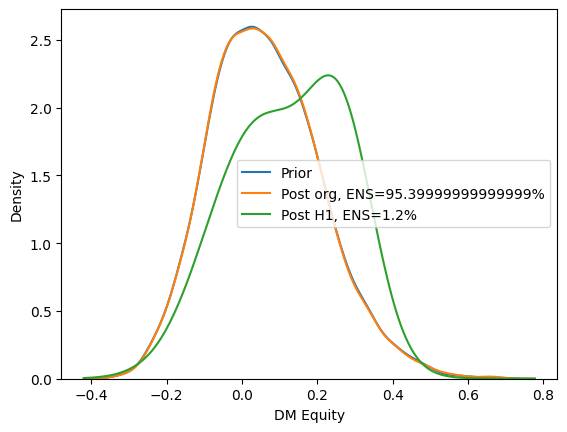

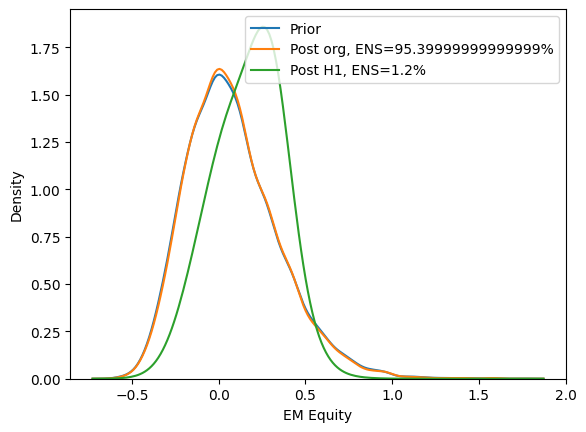

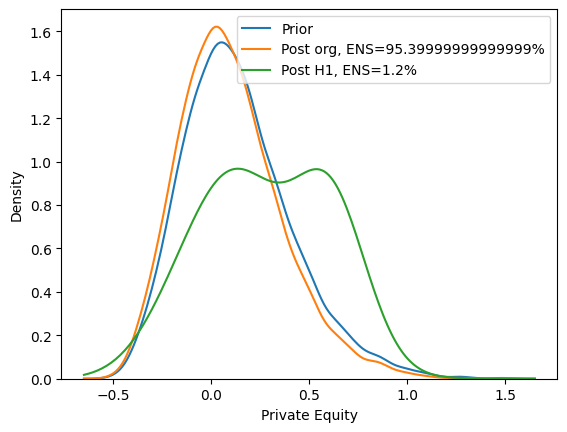

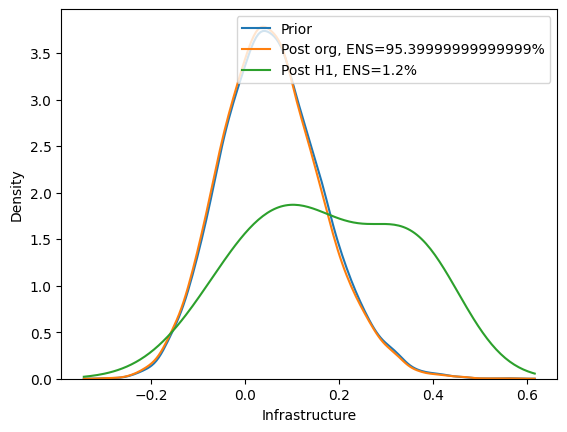

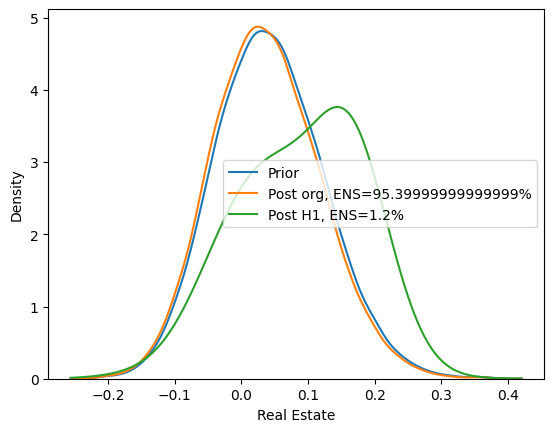

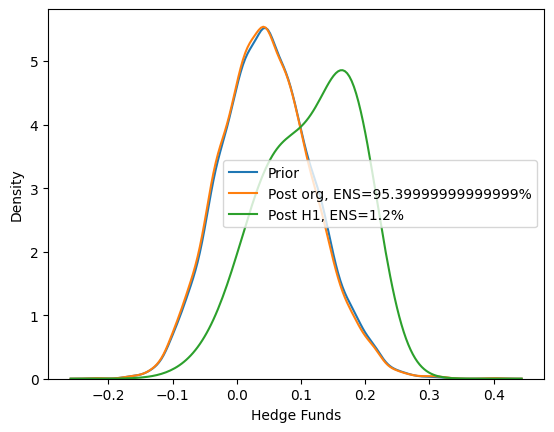

In [ ]:
for i in range(10):
  sns.kdeplot(x=R_df.iloc[:, i])
  sns.kdeplot(x=R_df.iloc[:, i], weights=q[:, 0])
  sns.kdeplot(x=R_df.iloc[:, i], weights=q1[:, 0])
  plt.legend(['Prior',
            f'Post org, ENS={100 * np.round(effective_number_scenarios[0, 0], 3)}%',
            f'Post H1, ENS={100 * np.round(effective_number_scenarios1[0, 0], 3)}%'])
  plt.show()

# Sequential heuristic (H2)

In [ ]:
# C0 views
mean_row = R[:, 1][np.newaxis]
A0 = np.vstack((np.ones((1, S)), mean_row))
b0 = np.array([[1.], [0.1]])
q0 = ft.entropy_pooling(p, A0, b0)

ft.simulation_moments(R_df, q0)


,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,0.052059,0.035737,-0.266208,2.265610
Corp IG,0.100000,0.044309,-0.181936,2.128673
Corp HY,0.096963,0.054581,-0.187032,3.268894
EM Debt,0.163537,0.080470,-0.513780,2.418053
DM Equity,0.138907,0.143354,-0.298493,2.541248
EM Equity,0.236400,0.252120,0.413821,4.009514
Private Equity,0.309116,0.298377,-0.188268,2.031546
Infrastructure,0.173938,0.155932,-0.087321,1.786859
Real Estate,0.096609,0.083638,-0.573675,2.526741
Hedge Funds,0.126293,0.074791,-0.099078,4.009661


In [ ]:
# C1 views
G = np.vstack((vol_rows[-1, :], skew_row, -kurt_row))
h = np.array([[0.2**2], [-0.75], [-3.5]])
means0 = q0.T @ R

G1 = np.vstack((np.ones((1, S)),vol_rows[-1, :]))
h1 = np.array([[1.],[0.2**2]])
q1 = ft.entropy_pooling(q0, A0, b0,G1,h1)  # H2: Use q0 instead of p

ft.simulation_moments(R_df, q1)


,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,0.054774,0.035654,-0.371903,2.323417
Corp IG,0.100000,0.044837,-0.170081,2.082054
Corp HY,0.088799,0.049755,-0.112197,3.493298
EM Debt,0.155484,0.078428,-0.382654,2.199343
DM Equity,0.125618,0.136872,-0.336705,2.008845
EM Equity,0.168497,0.179375,-0.297939,2.611375
Private Equity,0.285589,0.293248,-0.161561,1.781404
Infrastructure,0.173096,0.157480,-0.074595,1.765371
Real Estate,0.089374,0.084538,-0.400003,2.281638
Hedge Funds,0.115472,0.066862,-0.501841,2.197843


In [ ]:
# C2 views
G = np.vstack((vol_rows[-1, :], skew_row, -kurt_row))
h = np.array([[0.2**2], [-0.75], [-3.5]])
means0 = q1.T @ R  # Use updated parameters from q1

G2 = np.vstack((np.ones((1, S)),vol_rows[-1, :],skew_row))
h2 = np.array([[1.],[0.2**2],[-0.75]])
q2 = ft.entropy_pooling(q1, A0, b0,G2,h2)  # H2: Use q1 instead of p
ft.simulation_moments(R_df, q2)


,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,0.057860,0.032510,-0.302020,2.512401
Corp IG,0.100000,0.038539,-0.048611,2.475275
Corp HY,0.078716,0.048820,-0.088511,3.314295
EM Debt,0.142632,0.074625,-0.154740,2.378083
DM Equity,0.054061,0.170007,-0.324998,2.192497
EM Equity,0.090298,0.199738,-0.377252,2.435274
Private Equity,0.170860,0.327146,0.098553,1.791084
Infrastructure,0.148807,0.150632,0.132242,1.943268
Real Estate,0.070727,0.084268,-0.213496,2.490613
Hedge Funds,0.090357,0.077991,-0.329630,2.020381


In [ ]:
# C3 views
G = np.vstack((vol_rows[-1, :], skew_row, -kurt_row))
h = np.array([[0.2**2], [-0.75], [-3.5]])
means0 = q2.T @ R  # Use updated parameters from q2

G3 = np.vstack((np.ones((1, S)),vol_rows[-1, :],skew_row,-kurt_row))
h3 = np.array([[1.],[0.2**2],[-0.75],[-3.5]])
q3 = ft.entropy_pooling(q2, A0, b0,G3,h3)  # H2: Use q2 instead of p
ft.simulation_moments(R_df, q3)

relative_entropy2 = q3.T @ (np.log(q3) - np.log(p))  # Still calculate RE against original prior
effective_number_scenarios2 = np.exp(-relative_entropy2)
print(f'RE = {np.round(relative_entropy2[0, 0], 3)}.')
print(f'Relative ENS = {np.round(effective_number_scenarios2[0, 0], 3)}.')


RE = 4.391.
Relative ENS = 0.012.


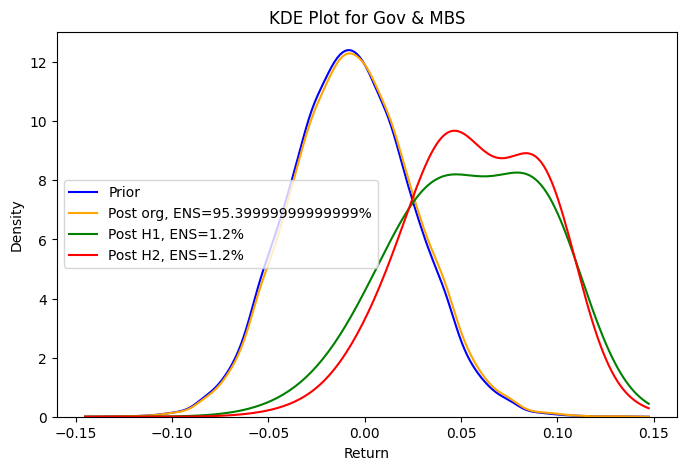

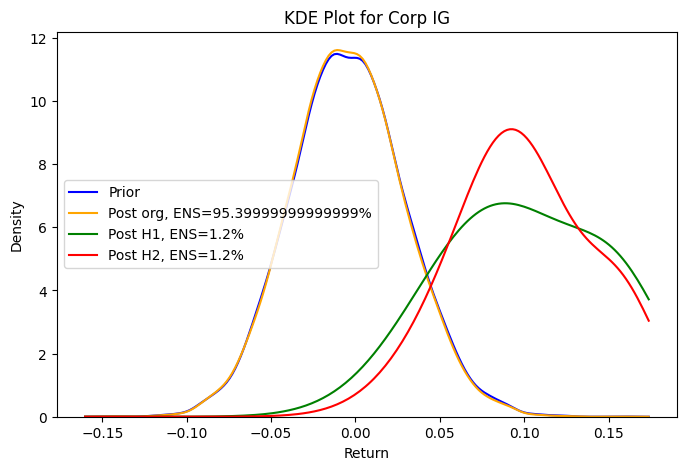

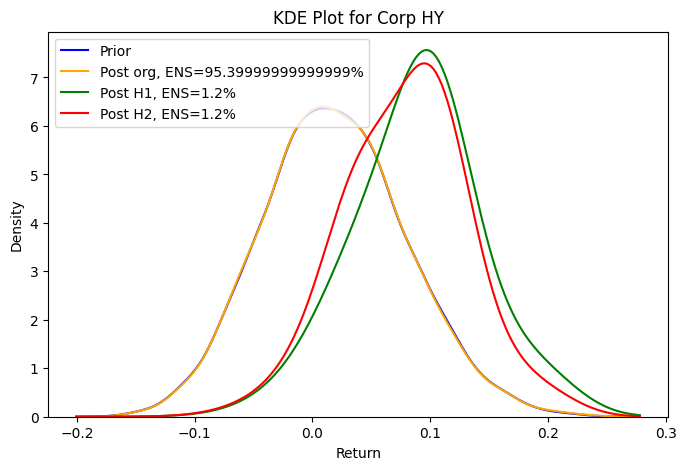

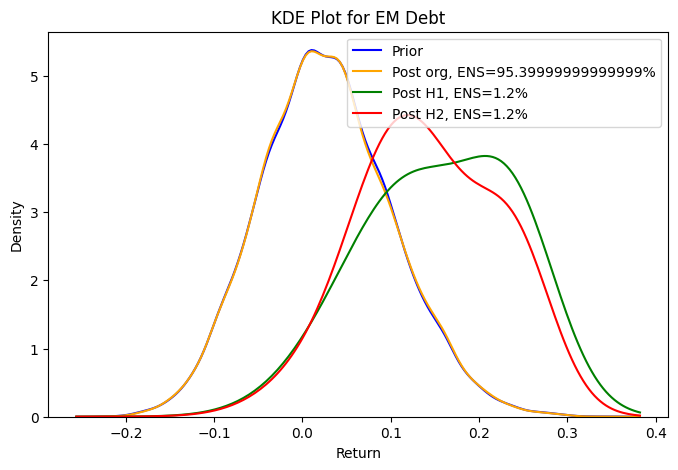

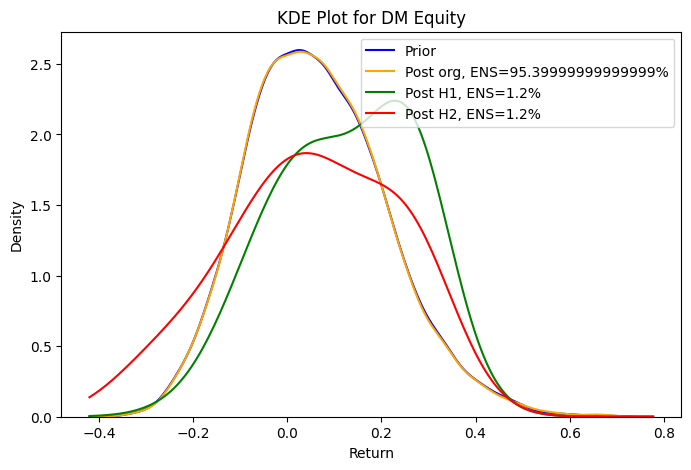

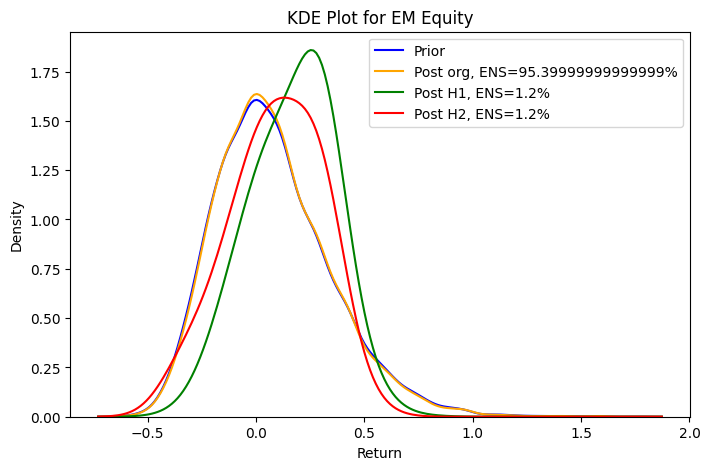

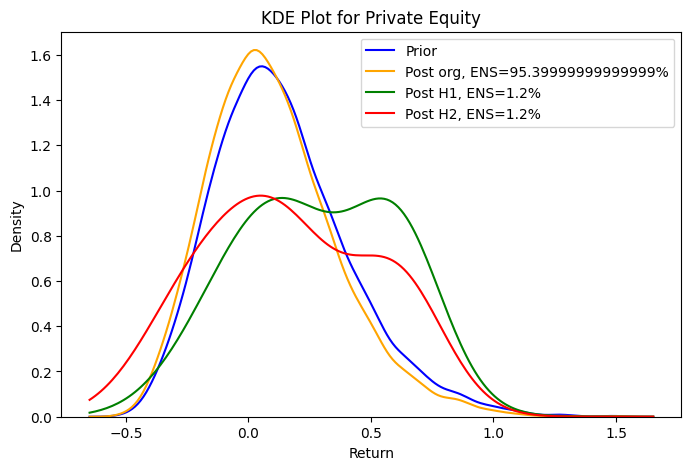

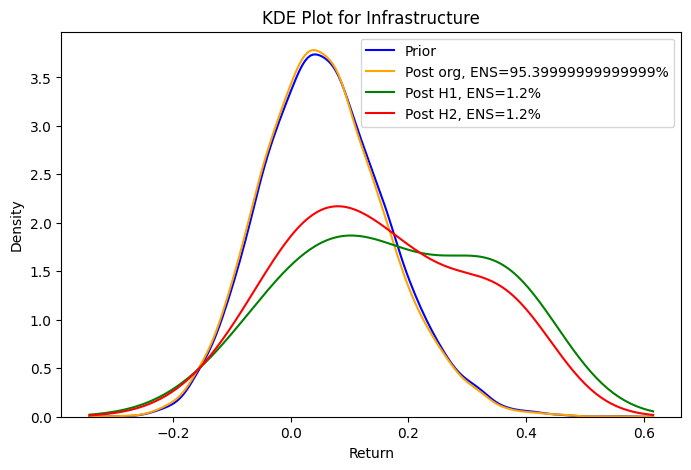

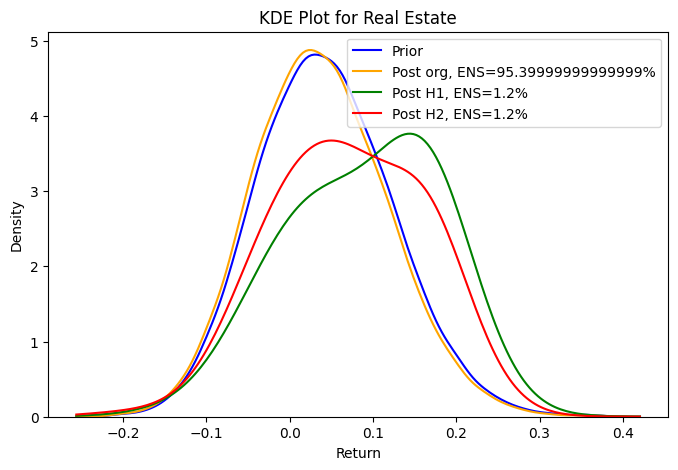

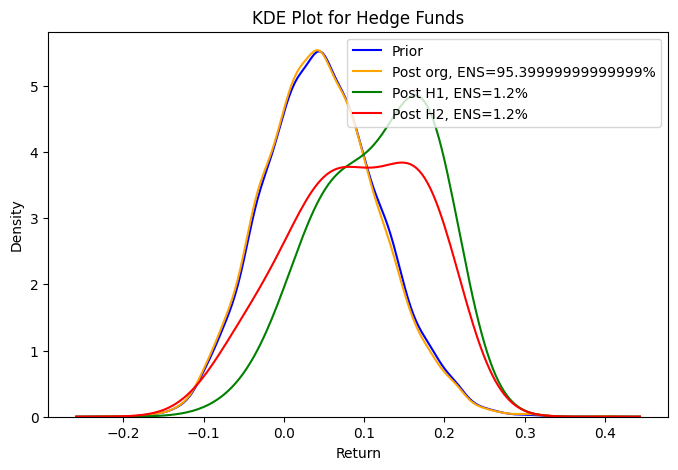

In [ ]:
for i in range(10):
    plt.figure(figsize=(8, 5))
    # Prior distribution
    sns.kdeplot(x=R_df.iloc[:, i], label='Prior', color='blue')
    # Original EP posterior
    sns.kdeplot(x=R_df.iloc[:, i], weights=q[:, 0],
                label=f'Post org, ENS={100 * np.round(effective_number_scenarios[0, 0], 3)}%',
                color='orange')
    # H1 posterior
    sns.kdeplot(x=R_df.iloc[:, i], weights=q1[:, 0],
                label=f'Post H1, ENS={100 * np.round(effective_number_scenarios1[0, 0], 3)}%',
                color='green')
    # H2 posterior - NEW ADDITION
    sns.kdeplot(x=R_df.iloc[:, i], weights=q2[:, 0],
                label=f'Post H2, ENS={100 * np.round(effective_number_scenarios2[0, 0], 3)}%',
                color='red')

    plt.legend()
    plt.title(f'KDE Plot for {R_df.columns[i]}')
    plt.xlabel('Return')
    plt.ylabel('Density')
    plt.show()